In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import normalize, MinMaxScaler
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# Loading data from NPY files
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
X_train_raw = np.load('X_train_raw.npy')
X_test_raw = np.load('X_test_raw.npy')

## Model Evaluation

In [3]:
# First column represents whether patient is male
m_index = np.where(X_test_raw[:, 0] == 1)
# Second column represents whether patient has scholarship 
scholarship_index = np.where(X_test_raw[:, 2] == 1)

# Divide into separate testing sets 
y_test_male = np.squeeze(np.take(y_test, m_index))
y_test_female = np.delete(y_test, m_index)
y_test_scholarship = np.squeeze(np.take(y_test, scholarship_index))
y_test_noscholarship = np.delete(y_test, scholarship_index)
y_test_list = [y_test, y_test_male, y_test_female, y_test_scholarship, y_test_noscholarship]

In [4]:
# Check that no data points were lost
print(len(y_test_male) + len(y_test_female))
print(len(y_test_scholarship) + len(y_test_noscholarship))
print(len(y_test))

22105
22105
22105


In [5]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, brier_score_loss
evaluation_stats = {}

# Helper function for displaying model evaluation metrics
def evaluate(y_pred, probs, model_name, print_toggle):
    # split predictions into 4 categories 
    y_pred_male = np.squeeze(np.take(y_pred, m_index))
    y_pred_female = np.delete(y_pred, m_index)
    y_pred_scholarship = np.squeeze(np.take(y_pred, scholarship_index))
    y_pred_noscholarship = np.delete(y_pred, scholarship_index)
    y_pred_list = [y_pred, y_pred_male, y_pred_female, y_pred_scholarship, y_pred_noscholarship]
    
    probs_male = np.squeeze(np.take(probs, m_index))
    probs_female = np.delete(probs, m_index)
    probs_scholarship = np.squeeze(np.take(probs, scholarship_index))
    probs_noscholarship = np.delete(probs, scholarship_index)
    probs_list = [probs, probs_male, probs_female, probs_scholarship, probs_noscholarship]
    
    
    # Organization of evaluation stats: 
    '''
    1. Whole: accuracy, recall, precision, false negative, false positive, positive, AUC, Brier 
    2. Male: accuracy, recall, precision, false negative, false positive, positive, AUC, Brier
    3. Female: accuracy, recall, precision, false negative, false positive, positive, AUC, Brier 
    4. Scholarship: accuracy, recall, precision, false negative, false positive, positive, AUC, Brier 
    5. No Scholarship: accuracy, recall, precision, false negative, false positive, positive, AUC, Brier 
    '''
    group_names = ["Overall", "Male", "Female", "Scholarship", "No Scholarship"]
    evaluation_stats[model_name] = {}
    
    for i in range(len(y_pred_list)):
        # convert from Boolean to 0 and 1 
        if (y_pred_list[i].dtype == bool):
            y_pred_list[i] = [1 if p == True else 0 for p in y_pred_list[i]]
        
        group = []
        
        # accuracy
        accuracy = accuracy_score(y_test_list[i], y_pred_list[i])
        group.append(accuracy)
        
        # recall
        recall = recall_score(y_test_list[i], y_pred_list[i])
        group.append(recall)
        
        # precision 
        precision = precision_score(y_test_list[i], y_pred_list[i])
        group.append(precision)
        
        # false negative and false positive 
        tn, fp, fn, tp = confusion_matrix(y_test_list[i], y_pred_list[i]).ravel()
        fnr = fn / len(y_test_list[i])
        group.append(fnr)
        fpr = fp / len(y_test_list[i])
        group.append(fpr)
        pos = (tp + fp) / len(y_test_list[i])
        group.append(pos)
        
        # AUC 
        auc = roc_auc_score(y_test_list[i], probs_list[i])
        group.append(auc)
        
        # Brier score 
        b_score = brier_score_loss(y_test_list[i], probs_list[i])
        group.append(b_score)
        
        evaluation_stats[model_name][group_names[i]] = group
        if(print_toggle):
            print(group_names[i])
            print("Accuracy: \t", accuracy)
            print("Recall: \t", recall)
            print("Precision: \t", precision)
            print("False Negative Rate: \t", fnr)
            print("False Positive Rate: \t", fpr)
            print("Positive Rate: \t", pos)
            print("AUC: \t", auc)
            print("Brier Score: \t", b_score)
            print()

## Linear Models

In [6]:
from sklearn import linear_model

### OLS

In [7]:
reg = linear_model.LinearRegression()
distributions = dict(fit_intercept=[True], normalize=[True])
clf = GridSearchCV(reg, distributions)
search = clf.fit(X_train, y_train)
print(search.best_params_)

y_cal = search.predict(X_test)

scaler = MinMaxScaler()
y_cal = scaler.fit_transform(y_cal.reshape(-1, 1))

y_pred = y_cal > 0.9
accuracy_score(y_test, y_pred)

{'fit_intercept': True, 'normalize': True}


0.7967880570006786

In [8]:
evaluate(y_pred, y_cal, "OLS", True)

Overall
Accuracy: 	 0.7967880570006786
Recall: 	 0.00423634336677815
Precision: 	 0.4222222222222222
False Negative Rate: 	 0.20203573852069667
False Positive Rate: 	 0.0011762044786247454
Positive Rate: 	 0.002035738520696675
AUC: 	 0.6724352267680007
Brier Score: 	 0.18822714960825607

Male
Accuracy: 	 0.7984697185838413
Recall: 	 0.001935483870967742
Precision: 	 0.3
False Negative Rate: 	 0.20062248735572558
False Positive Rate: 	 0.0009077940604331475
Positive Rate: 	 0.0012968486577616392
AUC: 	 0.6683515453607762
Brier Score: 	 0.18692359646514853

Female
Accuracy: 	 0.7958871752118939
Recall: 	 0.00545144804088586
Precision: 	 0.45714285714285713
False Negative Rate: 	 0.2027928303459775
False Positive Rate: 	 0.0013199944421286647
Positive Rate: 	 0.0024315687091843825
AUC: 	 0.6743972176635076
Brier Score: 	 0.18892547518047378

Scholarship
Accuracy: 	 0.7603603603603604
Recall: 	 0.007575757575757576
Precision: 	 0.3333333333333333
False Negative Rate: 	 0.23603603603603604


### Ridge Regression

In [9]:
reg = linear_model.Ridge(alpha=0.5)
reg.fit(X_train, y_train)
y_cal = reg.predict(X_test)

scaler = MinMaxScaler()
y_cal = scaler.fit_transform(y_cal.reshape(-1, 1))

y_pred = y_cal > 0.9
accuracy_score(y_test, y_pred)

0.7968332956344718

In [10]:
evaluate(y_pred, y_cal, "Ridge Regression", True)

Overall
Accuracy: 	 0.7968332956344718
Recall: 	 0.00423634336677815
Precision: 	 0.4318181818181818
False Negative Rate: 	 0.20203573852069667
False Positive Rate: 	 0.001130965844831486
Positive Rate: 	 0.0019904998869034155
AUC: 	 0.6723599790954082
Brier Score: 	 0.1883123287585906

Male
Accuracy: 	 0.7984697185838413
Recall: 	 0.001935483870967742
Precision: 	 0.3
False Negative Rate: 	 0.20062248735572558
False Positive Rate: 	 0.0009077940604331475
Positive Rate: 	 0.0012968486577616392
AUC: 	 0.6682586614028934
Brier Score: 	 0.18701267606435648

Female
Accuracy: 	 0.7959566486035848
Recall: 	 0.00545144804088586
Precision: 	 0.47058823529411764
False Negative Rate: 	 0.2027928303459775
False Positive Rate: 	 0.0012505210504376823
Positive Rate: 	 0.0023620953174934
AUC: 	 0.6743297524854556
Brier Score: 	 0.18900856482398176

Scholarship
Accuracy: 	 0.7603603603603604
Recall: 	 0.007575757575757576
Precision: 	 0.3333333333333333
False Negative Rate: 	 0.23603603603603604
Fals

### LASSO

In [11]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
y_cal = reg.predict(X_test)
y_pred = y_pred > 0.9

accuracy_score(y_test, y_pred)

0.7968332956344718

In [12]:
evaluate(y_pred, y_cal, "LASSO", True)

Overall
Accuracy: 	 0.7968332956344718
Recall: 	 0.00423634336677815
Precision: 	 0.4318181818181818
False Negative Rate: 	 0.20203573852069667
False Positive Rate: 	 0.001130965844831486
Positive Rate: 	 0.0019904998869034155
AUC: 	 0.5
Brier Score: 	 0.16173033976265916

Male
Accuracy: 	 0.7984697185838413
Recall: 	 0.001935483870967742
Precision: 	 0.3
False Negative Rate: 	 0.20062248735572558
False Positive Rate: 	 0.0009077940604331475
Positive Rate: 	 0.0012968486577616392
AUC: 	 0.5
Brier Score: 	 0.16060630543399013

Female
Accuracy: 	 0.7959566486035848
Recall: 	 0.00545144804088586
Precision: 	 0.47058823529411764
False Negative Rate: 	 0.2027928303459775
False Positive Rate: 	 0.0012505210504376823
Positive Rate: 	 0.0023620953174934
AUC: 	 0.5
Brier Score: 	 0.16233249543226919

Scholarship
Accuracy: 	 0.7603603603603604
Recall: 	 0.007575757575757576
Precision: 	 0.3333333333333333
False Negative Rate: 	 0.23603603603603604
False Positive Rate: 	 0.0036036036036036037
Pos

### Elastic Net

In [13]:
reg = linear_model.ElasticNet()
reg.fit(X_train, y_train)
y_cal = reg.predict(X_test)
y_pred = y_pred > 0.9

accuracy_score(y_test, y_pred)

0.7968332956344718

In [14]:
evaluate(y_pred, y_cal, "Elastic Net", True)

Overall
Accuracy: 	 0.7968332956344718
Recall: 	 0.00423634336677815
Precision: 	 0.4318181818181818
False Negative Rate: 	 0.20203573852069667
False Positive Rate: 	 0.001130965844831486
Positive Rate: 	 0.0019904998869034155
AUC: 	 0.5
Brier Score: 	 0.16173033976265916

Male
Accuracy: 	 0.7984697185838413
Recall: 	 0.001935483870967742
Precision: 	 0.3
False Negative Rate: 	 0.20062248735572558
False Positive Rate: 	 0.0009077940604331475
Positive Rate: 	 0.0012968486577616392
AUC: 	 0.5
Brier Score: 	 0.16060630543399013

Female
Accuracy: 	 0.7959566486035848
Recall: 	 0.00545144804088586
Precision: 	 0.47058823529411764
False Negative Rate: 	 0.2027928303459775
False Positive Rate: 	 0.0012505210504376823
Positive Rate: 	 0.0023620953174934
AUC: 	 0.5
Brier Score: 	 0.16233249543226919

Scholarship
Accuracy: 	 0.7603603603603604
Recall: 	 0.007575757575757576
Precision: 	 0.3333333333333333
False Negative Rate: 	 0.23603603603603604
False Positive Rate: 	 0.0036036036036036037
Pos

### Bayesian

In [15]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
y_cal = reg.predict(X_test)

scaler = MinMaxScaler()
y_cal = scaler.fit_transform(y_cal.reshape(-1, 1))

y_pred = y_cal > 0.9

accuracy_score(y_test, y_pred)

0.7962904320289528

In [16]:
evaluate(y_pred, y_cal, "Bayesian Ridge", True)

Overall
Accuracy: 	 0.7962904320289528
Recall: 	 0.004459308807134894
Precision: 	 0.3448275862068966
False Negative Rate: 	 0.2019904998869034
False Positive Rate: 	 0.0017190680841438588
Positive Rate: 	 0.0026238407600090476
AUC: 	 0.6722022835609175
Brier Score: 	 0.1904590270344852

Male
Accuracy: 	 0.7976916093891843
Recall: 	 0.001935483870967742
Precision: 	 0.1875
False Negative Rate: 	 0.20062248735572558
False Positive Rate: 	 0.001685903255090131
Positive Rate: 	 0.0020749578524186228
AUC: 	 0.6679170746265531
Brier Score: 	 0.1891130584595787

Female
Accuracy: 	 0.795539808253439
Recall: 	 0.005792163543441226
Precision: 	 0.40476190476190477
False Negative Rate: 	 0.2027233569542865
False Positive Rate: 	 0.001736834792274559
Positive Rate: 	 0.0029178824510212586
AUC: 	 0.674248490990693
Brier Score: 	 0.19118007494897066

Scholarship
Accuracy: 	 0.7603603603603604
Recall: 	 0.007575757575757576
Precision: 	 0.3333333333333333
False Negative Rate: 	 0.23603603603603604
F

### Logistic

In [17]:
clf = linear_model.LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7936665912689437

In [18]:
# uncalibrated 
y_uncal = clf.predict_proba(X_test)[:, 1]
# calibrated 
calibrator = CalibratedClassifierCV(clf, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

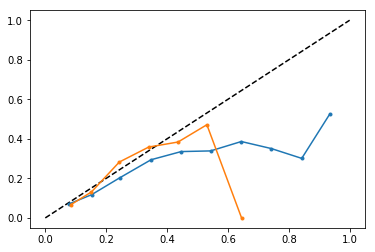

In [19]:
# Plot calibrated results 
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_uncal, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_cal, n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
pyplot.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
pyplot.plot(mpv_calibrated, fop_calibrated, marker='.')
pyplot.show()

In [20]:
evaluate(y_pred, y_cal, "Logistic", True)

Overall
Accuracy: 	 0.7936665912689437
Recall: 	 0.020289855072463767
Precision: 	 0.35271317829457366
False Negative Rate: 	 0.198778556887582
False Positive Rate: 	 0.007554851843474327
Positive Rate: 	 0.011671567518660936
AUC: 	 0.6775423944362404
Brier Score: 	 0.1524647942519026

Male
Accuracy: 	 0.7960057061340942
Recall: 	 0.016129032258064516
Precision: 	 0.3424657534246575
False Negative Rate: 	 0.19776942030864997
False Positive Rate: 	 0.006224873557255868
Positive Rate: 	 0.009466995201659967
AUC: 	 0.6791451429648518
Brier Score: 	 0.15115797623045435

Female
Accuracy: 	 0.7924135056273447
Recall: 	 0.022487223168654175
Precision: 	 0.3567567567567568
False Negative Rate: 	 0.19931916076142836
False Positive Rate: 	 0.0082673336112269
Positive Rate: 	 0.012852577462831735
AUC: 	 0.6766216953324296
Brier Score: 	 0.15316486884988695

Scholarship
Accuracy: 	 0.7567567567567568
Recall: 	 0.030303030303030304
Precision: 	 0.36363636363636365
False Negative Rate: 	 0.230630630

## SVM

In [21]:
from sklearn.svm import SVC
svm = SVC()
distributions = dict(C = [100], 
                     kernel = ["rbf"], 
                     max_iter = [10], 
                     degree = [2], 
                     #gamma = ["scale", "auto"], 
                     shrinking = [True], 
                     probability = [True])
clf = GridSearchCV(svm, distributions)
search = clf.fit(X_train, y_train)
print(search.best_params_)

y_pred = search.predict(X_test)
accuracy_score(y_test, y_pred)

{'C': 100, 'degree': 2, 'kernel': 'rbf', 'max_iter': 10, 'probability': True, 'shrinking': True}


0.7961999547613662

In [22]:
# uncalibrated 
y_uncal = search.predict_proba(X_test)[:, 1]
# calibrated 
calibrator = CalibratedClassifierCV(search, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

In [23]:
evaluate(y_pred, y_cal, "SVM", True)

Overall
Accuracy: 	 0.7961999547613662
Recall: 	 0.0006688963210702341
Precision: 	 0.11538461538461539
False Negative Rate: 	 0.2027595566613888
False Positive Rate: 	 0.001040488577244967
Positive Rate: 	 0.0011762044786247454
AUC: 	 0.5812167623950183
Brier Score: 	 0.16080207608070418

Male
Accuracy: 	 0.7988587731811697
Recall: 	 0.0006451612903225806
Precision: 	 0.3333333333333333
False Negative Rate: 	 0.2008818570872779
False Positive Rate: 	 0.00025936973155232785
Positive Rate: 	 0.00038905459732849174
AUC: 	 0.6001246655601573
Brier Score: 	 0.15965902948057165

Female
Accuracy: 	 0.7947756009448381
Recall: 	 0.0006814310051107325
Precision: 	 0.08695652173913043
False Negative Rate: 	 0.20376545782965125
False Positive Rate: 	 0.0014589412255106293
Positive Rate: 	 0.0015978880088925941
AUC: 	 0.580097311606315
Brier Score: 	 0.16141441680139487

Scholarship
Accuracy: 	 0.7617117117117117
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.23783783783783785
False Posit

## SGD

In [24]:
reg = linear_model.SGDClassifier()
distributions = dict(loss=["hinge"], 
                     penalty=["l1"], 
                     max_iter=[20])
clf = GridSearchCV(reg, distributions)
search = clf.fit(X_train, y_train)
print(search.best_params_)

y_pred = search.predict(X_test)
accuracy_score(y_test, y_pred)

{'loss': 'hinge', 'max_iter': 20, 'penalty': 'l1'}


0.7971047274372314

In [25]:
# uncalibrated 
y_uncal = search.decision_function(X_test)
# calibrated 
calibrator = CalibratedClassifierCV(search, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

In [26]:
evaluate(y_pred, y_cal, "SGD", True)

Overall
Accuracy: 	 0.7971047274372314
Recall: 	 0.001560758082497213
Precision: 	 0.5
False Negative Rate: 	 0.20257860212621578
False Positive Rate: 	 0.0003166704365528161
Positive Rate: 	 0.0006333408731056322
AUC: 	 0.461216477677515
Brier Score: 	 0.16173733422012831

Male
Accuracy: 	 0.7987290883153936
Recall: 	 0.0012903225806451613
Precision: 	 0.3333333333333333
False Negative Rate: 	 0.20075217222150174
False Positive Rate: 	 0.0005187394631046557
Positive Rate: 	 0.0007781091946569835
AUC: 	 0.47885916090286973
Brier Score: 	 0.16059819561036737

Female
Accuracy: 	 0.7962345421703487
Recall: 	 0.0017035775127768314
Precision: 	 0.625
False Negative Rate: 	 0.2035570376545783
False Positive Rate: 	 0.00020842017507294707
Positive Rate: 	 0.0005557871335278589
AUC: 	 0.4510287547649698
Brier Score: 	 0.16234758139394145

Scholarship
Accuracy: 	 0.763063063063063
Recall: 	 0.003787878787878788
Precision: 	 1.0
False Negative Rate: 	 0.23693693693693693
False Positive Rate: 	 0

## Nearest Neighbors

In [27]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
distributions = dict(weights = ["uniform"], 
                     algorithm = ["kd_tree"], 
                     n_neighbors = [8], 
                     leaf_size = [20], 
                     p = [1])
clf = GridSearchCV(neigh, distributions)
search = clf.fit(X_train, y_train)
print(search.best_params_)

y_pred = search.predict(X_test)
accuracy_score(y_test, y_pred)

{'algorithm': 'kd_tree', 'leaf_size': 20, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}


0.7945713639448089

In [28]:
# uncalibrated 
y_uncal = search.predict_proba(X_test)
# calibrated 
calibrator = CalibratedClassifierCV(search, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

In [29]:
evaluate(y_pred, y_cal, "kNN", True)

Overall
Accuracy: 	 0.7945713639448089
Recall: 	 0.09921962095875139
Precision: 	 0.4704016913319239
False Negative Rate: 	 0.18276408052476814
False Positive Rate: 	 0.022664555530422983
Positive Rate: 	 0.042795747568423435
AUC: 	 0.7892058659398146
Brier Score: 	 0.14453212900988727

Male
Accuracy: 	 0.7956166515367656
Recall: 	 0.10064516129032258
Precision: 	 0.46153846153846156
False Negative Rate: 	 0.1807807028919725
False Positive Rate: 	 0.023602645571261835
Positive Rate: 	 0.043833484632343406
AUC: 	 0.7847869794911801
Brier Score: 	 0.14429780023787445

Female
Accuracy: 	 0.7940113936362373
Recall: 	 0.09846678023850085
Precision: 	 0.4753289473684211
False Negative Rate: 	 0.1838265944143393
False Positive Rate: 	 0.022162011949423372
Positive Rate: 	 0.04223982214811727
AUC: 	 0.7915899407605783
Brier Score: 	 0.14465766111777878

Scholarship
Accuracy: 	 0.7662162162162162
Recall: 	 0.12878787878787878
Precision: 	 0.5354330708661418
False Negative Rate: 	 0.207207207207

## Naive Bayes

### Bernoulli NB

In [30]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
distributions = dict(alpha = [0.5])
clf = GridSearchCV(bnb, distributions)
search = clf.fit(X_train, y_train)
print(search.best_params_)

y_pred = search.predict(X_test)
accuracy_score(y_test, y_pred)

{'alpha': 0.5}


0.7710925130061073

In [31]:
# uncalibrated 
y_uncal = search.predict_proba(X_test)
# calibrated 
calibrator = CalibratedClassifierCV(search, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

In [32]:
evaluate(y_pred, y_cal, "Bernoulli NB", True)

Overall
Accuracy: 	 0.7710925130061073
Recall: 	 0.14983277591973243
Precision: 	 0.3501823866597186
False Negative Rate: 	 0.17249491065369826
False Positive Rate: 	 0.056412576340194524
Positive Rate: 	 0.08681293824926488
AUC: 	 0.6648714721919577
Brier Score: 	 0.15411645179896033

Male
Accuracy: 	 0.774478018415251
Recall: 	 0.13870967741935483
Precision: 	 0.3473344103392569
False Negative Rate: 	 0.17312929581117883
False Positive Rate: 	 0.05239268577357022
Positive Rate: 	 0.08027493191544546
AUC: 	 0.6699086867967601
Brier Score: 	 0.15260145707212036

Female
Accuracy: 	 0.7692788661942476
Recall: 	 0.1557069846678024
Precision: 	 0.3515384615384615
False Negative Rate: 	 0.17215506461025426
False Positive Rate: 	 0.05856606919549812
Positive Rate: 	 0.09031540919827706
AUC: 	 0.6622309625324447
Brier Score: 	 0.15492804859892303

Scholarship
Accuracy: 	 0.7337837837837838
Recall: 	 0.19128787878787878
Precision: 	 0.38113207547169814
False Negative Rate: 	 0.1923423423423423

### Gaussian NB

In [33]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train_raw, y_train).predict(X_test_raw)
accuracy_score(y_test, y_pred)

0.4878081881927166

In [34]:
# uncalibrated 
y_uncal = gnb.predict_proba(X_test)
# calibrated 
calibrator = CalibratedClassifierCV(gnb, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

In [35]:
evaluate(y_pred, y_cal, "Gaussian NB", True)

Overall
Accuracy: 	 0.4878081881927166
Recall: 	 0.6630992196209587
Precision: 	 0.23261634728197106
False Negative Rate: 	 0.06835557566161501
False Positive Rate: 	 0.4438362361456684
Positive Rate: 	 0.578375933046822
AUC: 	 0.5919123652178976
Brier Score: 	 0.16153578551099235

Male
Accuracy: 	 0.48151990662689664
Recall: 	 0.6567741935483871
Precision: 	 0.22702943800178413
False Negative Rate: 	 0.06899234859291921
False Positive Rate: 	 0.44948774478018416
Positive Rate: 	 0.5815069381403191
AUC: 	 0.5926374017623867
Brier Score: 	 0.16040401859245665

Female
Accuracy: 	 0.4911768792552452
Recall: 	 0.6664395229982965
Precision: 	 0.2356342609324178
False Negative Rate: 	 0.06801445046547172
False Positive Rate: 	 0.44080867027928305
Positive Rate: 	 0.5766986244268445
AUC: 	 0.5914890849280741
Brier Score: 	 0.16214208360108742

Scholarship
Accuracy: 	 0.43873873873873875
Recall: 	 0.7253787878787878
Precision: 	 0.2580862533692722
False Negative Rate: 	 0.06531531531531531
Fal

## Decision Trees

In [36]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
distributions = dict(criterion = ["gini"], 
                     splitter = ["random"], 
                     max_depth = [5], 
                     max_features = ["auto"])
clf = GridSearchCV(dt, distributions)
search = clf.fit(X_train, y_train)
print(search.best_params_)

y_pred = search.predict(X_test)
accuracy_score(y_test, y_pred)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'splitter': 'random'}


0.7971047274372314

In [37]:
# uncalibrated 
y_uncal = search.predict_proba(X_test)
# calibrated 
calibrator = CalibratedClassifierCV(search, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

In [38]:
evaluate(y_pred, y_cal, "Decision Trees", True)

Overall
Accuracy: 	 0.7971047274372314
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.2028952725627686
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.6393759308680594
Brier Score: 	 0.15711109499588718

Male
Accuracy: 	 0.798988458046946
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.20101154195305407
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.6342866941374201
Brier Score: 	 0.156236971479417

Female
Accuracy: 	 0.7960955953869668
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.20390440461303322
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.6420115237898005
Brier Score: 	 0.15757937111340156

Scholarship
Accuracy: 	 0.7621621621621621
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.23783783783783785
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.6339844589512144
Brier Score: 	 0.17663649262039752

No Scholarship
Accuracy: 	 0.8010057832537089
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.1989942167

## Ensemble Methods

### Random Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
distributions = dict(n_estimators = [10], 
                     criterion = ["entropy"], 
                     max_depth = [None], 
                     max_features = ["auto"], 
                     class_weight = ["balanced_subsample"])
clf = GridSearchCV(rf, distributions)
search = clf.fit(X_train, y_train)
print(search.best_params_)

y_pred = search.predict(X_test)
accuracy_score(y_test, y_pred)

{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 10}


0.7831712282289075

In [41]:
# uncalibrated 
y_uncal = search.predict_proba(X_test)
# calibrated 
calibrator = CalibratedClassifierCV(search, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

In [42]:
evaluate(y_pred, y_cal, "Random Forest", True)

Overall
Accuracy: 	 0.7831712282289075
Recall: 	 0.1930880713489409
Precision: 	 0.4245098039215686
False Negative Rate: 	 0.16371861569780594
False Positive Rate: 	 0.053110156073286584
Positive Rate: 	 0.09228681293824927
AUC: 	 0.997993741276572
Brier Score: 	 0.09255396136547199

Male
Accuracy: 	 0.7902995720399429
Recall: 	 0.20258064516129032
Precision: 	 0.45179856115107914
False Negative Rate: 	 0.1602904940993386
False Positive Rate: 	 0.04940993386071845
Positive Rate: 	 0.09013098171443393
AUC: 	 0.9980557199030321
Brier Score: 	 0.09209011484157929

Female
Accuracy: 	 0.77935250798944
Recall: 	 0.18807495741056218
Precision: 	 0.4104089219330855
False Negative Rate: 	 0.16555509239961094
False Positive Rate: 	 0.05509239961094901
Positive Rate: 	 0.09344171182437126
AUC: 	 0.9979680166293189
Brier Score: 	 0.09280244827291514

Scholarship
Accuracy: 	 0.7567567567567568
Recall: 	 0.20075757575757575
Precision: 	 0.4732142857142857
False Negative Rate: 	 0.1900900900900901
Fa

### AdaBoost

In [43]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
distributions = dict(n_estimators = [50], 
                     algorithm = ["SAMME"], 
                     learning_rate = [0.5])
clf = GridSearchCV(ada, distributions)
search = clf.fit(X_train, y_train)
print(search.best_params_)

y_pred = search.predict(X_test)
accuracy_score(y_test, y_pred)

{'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 50}


0.7971047274372314

In [44]:
# uncalibrated 
y_uncal = search.predict_proba(X_test)
# calibrated 
calibrator = CalibratedClassifierCV(search, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

In [45]:
evaluate(y_pred, y_cal, "AdaBoost", True)

Overall
Accuracy: 	 0.7971047274372314
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.2028952725627686
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.7242065998782674
Brier Score: 	 0.1458455101691887

Male
Accuracy: 	 0.798988458046946
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.20101154195305407
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.7245646653507233
Brier Score: 	 0.14543161935942214

Female
Accuracy: 	 0.7960955953869668
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.20390440461303322
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.7244216511188025
Brier Score: 	 0.14606723533482088

Scholarship
Accuracy: 	 0.7621621621621621
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.23783783783783785
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.7194758981660576
Brier Score: 	 0.16243477834531356

No Scholarship
Accuracy: 	 0.8010057832537089
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.198994216

## Neural Network Models

In [46]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier()
distributions = dict(hidden_layer_sizes = [(50,)], 
                     activation = ["logistic"], 
                     solver = ["sgd"], 
                     alpha = [0.0001], 
                     batch_size = ["auto"], 
                     learning_rate = ["invscaling"], 
                     max_iter = [100], 
                     shuffle = [False], 
                     early_stopping = [True], 
                     validation_fraction = [0.1])
clf = GridSearchCV(nn, distributions)
search = clf.fit(X_train, y_train)
print(search.best_params_)

y_pred = search.predict(X_test)
accuracy_score(y_test, y_pred)

{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 100, 'shuffle': False, 'solver': 'sgd', 'validation_fraction': 0.1}


0.7971047274372314

In [47]:
# uncalibrated 
y_uncal = search.predict_proba(X_test)
# calibrated 
calibrator = CalibratedClassifierCV(search, cv = 3)
calibrator.fit(X_test, y_test)
y_cal = calibrator.predict_proba(X_test)[:, 1]

In [48]:
evaluate(y_pred, y_cal, "Neural Net", True)

Overall
Accuracy: 	 0.7971047274372314
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.2028952725627686
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.5375117714869972
Brier Score: 	 0.16150615564522286

Male
Accuracy: 	 0.798988458046946
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.20101154195305407
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.5390387505170401
Brier Score: 	 0.1603910168461969

Female
Accuracy: 	 0.7960955953869668
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.20390440461303322
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.5371160464989393
Brier Score: 	 0.16210354589666714

Scholarship
Accuracy: 	 0.7621621621621621
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.23783783783783785
False Positive Rate: 	 0.0
Positive Rate: 	 0.0
AUC: 	 0.5163430627193926
Brier Score: 	 0.18215918838430137

No Scholarship
Accuracy: 	 0.8010057832537089
Recall: 	 0.0
Precision: 	 0.0
False Negative Rate: 	 0.198994216

## Export Evaluation Metrics to Text File

In [49]:
import pprint

pprint.pprint(evaluation_stats)

{'AdaBoost': {'Female': [0.7960955953869668,
                         0.0,
                         0.0,
                         0.20390440461303322,
                         0.0,
                         0.0,
                         0.7244216511188025,
                         0.14606723533482088],
              'Male': [0.798988458046946,
                       0.0,
                       0.0,
                       0.20101154195305407,
                       0.0,
                       0.0,
                       0.7245646653507233,
                       0.14543161935942214],
              'No Scholarship': [0.8010057832537089,
                                 0.0,
                                 0.0,
                                 0.19899421674629117,
                                 0.0,
                                 0.0,
                                 0.7234123082554842,
                                 0.14399345206755446],
              'Overall': [0.7971047274372314

In [50]:
f = open("evaluation_stats.txt","w")
f.write( str(evaluation_stats) )
f.close()

## Testing Statistical Significance 

In [51]:
'''
from scipy import stats 
print(evaluation_stats)
print(len(evaluation_stats))
print(evaluation_stats.keys())
# accuracy, recall, precision, false negative, false positive, positive, AUC, Brier 
for model in evaluation_stats.keys():
    print(model)
    # statistical significace in terms of gender
    print(evaluation_stats[model]['Male'])
    print(evaluation_stats[model]['Female'])
    # accuracy

    # statistical significane in terms of scholarship 
    print(evaluation_stats[model]['Scholarship'])
    print(evaluation_stats[model]['No Scholarship'])
'''

"\nfrom scipy import stats \nprint(evaluation_stats)\nprint(len(evaluation_stats))\nprint(evaluation_stats.keys())\n# accuracy, recall, precision, false negative, false positive, positive, AUC, Brier \nfor model in evaluation_stats.keys():\n    print(model)\n    # statistical significace in terms of gender\n    print(evaluation_stats[model]['Male'])\n    print(evaluation_stats[model]['Female'])\n    # accuracy\n\n    # statistical significane in terms of scholarship \n    print(evaluation_stats[model]['Scholarship'])\n    print(evaluation_stats[model]['No Scholarship'])\n"

## Exporting a Dataset to use in Simulation 

In [52]:
# the data set used for the simulation will include patients from both the testing and training set 
# features include patient gender, scholarship, show probability predicted from the ML algorithm of choice, 
# and whether the patient actually shows up for their appointment (1 for show, 0 for no-show)

# selected ML algorithm: Neural network (UPDATE)
y_train_pred = search.predict(X_train)

y_pred = search.predict(X_test)

simulation_dataset = []

for i in range(len(y_train_pred)):
    row = []
    # add gender
    row.append(X_train_raw[i][0])
    # add scholarship
    row.append(X_train_raw[i][2])
    # add predicted show probaiblity 
    row.append(1 - y_train_pred[i])
    # add whether the patient actually showed up 
    row.append(1 - y_train[i])
    simulation_dataset.append(row)

for i in range(len(y_cal)):
    row = []
    # add gender
    row.append(X_test_raw[i][0])
    # add scholarship
    row.append(X_test_raw[i][2])
    # add predicted show probaiblity 
    row.append(1 - y_cal[i])
    # add whether the patient actually showed up 
    row.append(1 - y_test[i])
    simulation_dataset.append(row)


In [53]:
np.save('simulation_dataset.npy', simulation_dataset)